# CNN from scratch

In this notebook, I implement a simple Convolutional Neural Network (CNN), along with other components, from scratch in PyTorch and test it with the CIFAR-10 dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from typing import Tuple

## Helper functions

I use the following functions to verify the correctness of my implementations.

In [2]:
def verify_conv2d():
    x = torch.randn(1, 3, 32, 32)
    in_channels = 3
    out_channels = 16
    kernel_size = 3
    stride = 1
    padding = 1

    conv_pytorch = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    output_pytorch = conv_pytorch(x)

    conv_custom = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    conv_custom.weight.data = conv_pytorch.weight.data.clone()
    conv_custom.bias.data = conv_pytorch.bias.data.clone()
    output_custom = conv_custom(x)
    difference = (output_pytorch - output_custom).abs().max()
    return (difference < 1e-06).item()

In [3]:
@torch.no_grad
def verify_dropout():
    p = 0.8
    n = int(1e5)
    x = torch.randn(5,)
    weight = torch.randn(5,)

    y = torch.dot(x, weight)
    print('x dot product weight', y)

    dropout_pytorch = nn.Dropout(p)
    dropout_custom = Dropout(p)

    dropout_pytorch.eval()
    dropout_custom.eval()

    output_pytorch = dropout_pytorch(y)
    output_custom = dropout_custom(y)
    assert torch.allclose(output_pytorch, output_custom), "The outputs are not the same in evaluation mode."

    dropout_pytorch.train()
    dropout_custom.train()

    pytorch_dropout_train = torch.zeros_like(output_pytorch)
    custom_dropout_train = torch.zeros_like(output_custom)

    for _ in range(n):
        x_hat = dropout_pytorch(x)
        pytorch_dropout_train += torch.dot(x_hat, weight)
        x_hat = dropout_custom(x)
        custom_dropout_train += torch.dot(x_hat, weight)

    pytorch_dropout_train /= n
    custom_dropout_train /= n

    print('Empirical mean of Pytorch Dropout result', pytorch_dropout_train)
    print('Empirical mean of Custom Dropout result', custom_dropout_train)

In [4]:
@torch.no_grad
def verify_batchnorm():
    x = torch.randn(2, 3, 4, 4)

    num_features = x.shape[1]

    custom_bn = BatchNorm2d(num_features, eps=1e-5, momentum=0.1)
    pytorch_bn = nn.BatchNorm2d(num_features, eps=1e-5, momentum=0.1)

    pytorch_bn.weight.data = custom_bn.weight.data.clone()
    pytorch_bn.bias.data = custom_bn.bias.data.clone()
    pytorch_bn.running_mean = custom_bn.running_mean.clone()
    pytorch_bn.running_var = custom_bn.running_var.clone()

    custom_bn.train()
    pytorch_bn.train()

    output_custom = custom_bn(x)
    output_pytorch = pytorch_bn(x)

    difference = (output_custom - output_pytorch).abs().max()
    return (difference < 1e-06).item()

In [5]:
@torch.no_grad
def eval_accuracy(model, eval_loader: DataLoader, device):
    model.eval()
    n_correct = 0
    n_total = 0
    for imgs, labels in eval_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        _, pred = torch.max(logits, 1)

        n_correct += (pred == labels).sum().item()
        n_total += len(labels)

    return n_correct / n_total

In [6]:
def plot_curves(train_error_rates, val_error_rates):
    plt.figure(figsize=(10, 6))
    # epochs = range(1, len(train_error_rates) + 1)
    epochs = [i*20 for i in range(1, len(train_error_rates) + 1)]
    plt.plot(epochs, train_error_rates, 'bo-', label='Training Error')
    plt.plot(epochs, val_error_rates, 'ro-', label='Validation Error')
    plt.title('Training and Validation Error Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_batch(data_loader):
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    fig = plt.figure(figsize=(25, 4))
    for idx in range(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

# Load and prepare the datasets

First, we split the dataset into training, validation, and test datasets and apply some transformations to them. Note that the train-validation split is 80%.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.manual_seed(2024)

In [9]:
batch_size = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
])


train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 79537114.45it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [10]:
def build_loaders(train_data: torch.utils.data.Dataset,
                  test_data: torch.utils.data.Dataset,
                  train_ratio: float=0.8,
                  val_ratio: float=0.2,
                  batch_size:int=batch_size) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Args:
    - train_data: CIFAR-10 train data
    - test_data: CIFAR-10 test data
    - train_ratio: ratio of training
    - val_ratio: ratio of validation
    - batch_size: Batch size
    Returns:
    - train_loader: Dataloader for training
    - val_loader: Dataloader for validation
    - test_loader: Dataloader for test
    """
    # Split into training and validtion sets
    train, val = random_split(train_data, [train_ratio, val_ratio], generator=generator)

    # Create DataLoaders
    train_loader = DataLoader(train, batch_size=batch_size) #, num_workers=8)
    val_loader = DataLoader(val, batch_size=batch_size) #, num_workers=8)
    test_loader = DataLoader(test_data, batch_size=batch_size) #, num_workers=8)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = build_loaders(train_data, test_data)

### Visualize a Batch of Training Data

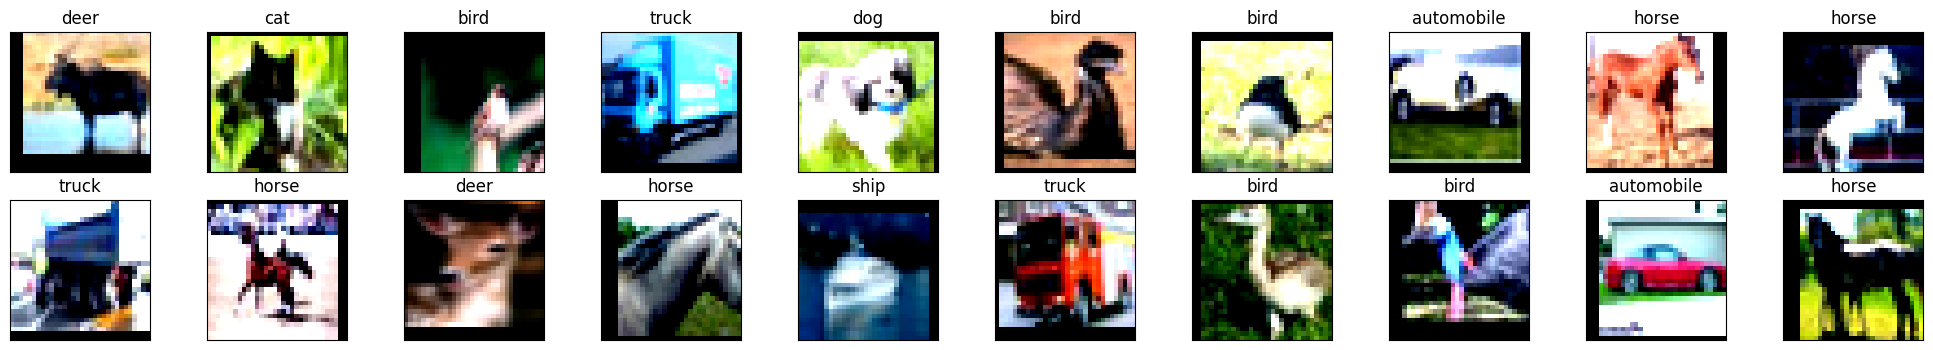

In [11]:
show_batch(train_loader)

# Implement Conv2d

Here's my implementation of the convolutional layer Conv2d, similar to PyTorch's `torch.nn.Conv2d`. The main challenge for this part was implementing the convolution operation successfully in the `forward` method, which I was able to do rather succinctly thanks to Python's handy list comprehension notation.

In [12]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv2d, self).__init__()

        assert in_channels > 0 and out_channels > 0 and kernel_size > 0
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: convoluted tensor
        """
        # Get input dimensions
        n, c, h, w = x.shape

        # Get output dimensions
        out_h = ((h + 2 * self.padding - self.kernel_size) // self.stride) + 1 # // is floor division
        out_w = ((w + 2 * self.padding - self.kernel_size) // self.stride) + 1

        # Create output tensor
        output = torch.zeros(n, self.weight.shape[0], out_h, out_w)

        # Pad input tensor
        x_padded = F.pad(x, (self.padding, self.padding, self.padding, self.padding))

        for i in range(self.out_channels):
            for y in range(out_h):
                for x in range(out_w):
                    output[:, i, y, x] = (self.weight[i] * x_padded[:, :, y*self.stride:y*self.stride+self.kernel_size, x*self.stride:x*self.stride+self.kernel_size]).sum(dim=(1,2,3)) + self.bias[i]

        return output

# Test Conv2d
conv2d_passed = verify_conv2d()
print('Passed conv2d test:', conv2d_passed)

Passed conv2d test: True


# Implement Dropout Layer

Now, I implement my own Dropout layer as well and compare its output to PyTorch's `Dropout` layer to test correctness.

In [13]:
class Dropout(nn.Module):
    def __init__(self, p):
        super(Dropout, self).__init__()
        """
        Args:
        - p: dropout rate
        """
        assert p >= 0 and p <= 1
        self.p = p

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: dropout tensor
        """
        if self.training:
            mask = torch.rand_like(x) > self.p
            return (x * mask) / (1 - self.p) # Scaling factor (inverse of keep probability)
        else:
            return x

# Test
verify_dropout()

x dot product weight tensor(-1.9127)
Empirical mean of Pytorch Dropout result tensor(-1.8975)
Empirical mean of Custom Dropout result tensor(-1.9101)


# Implement BatchNorm2d

Now, I implement the BatchNorm2d class and compare its output to that of PyTorch's `BatchNorm2d` class.

### Mathematical background

During training, we are given a batch $\mathcal{B} = \{\mathbf{x}^{(1)}, \dots, \mathbf{x}^{(m)}\}$ with size $m$. Suppose $\mathbf{x} \in \mathbf{R}^d$. We use $\mathbf{x}^{(i)}_j$ to represent $j$-th element in $i$-th sample. For each channel, we need to compute
$\boldsymbol{\mu}_{j} = \frac{1}{m}\sum_{i=1}^{m} \mathbf{x}^{(i)}_j$ and
$\boldsymbol{\sigma}_{j}^2 = \frac{1}{m}\sum_{i=1}^m (\mathbf{x}^{(i)}_j - \boldsymbol{\mu}_j)^2.$ Then, there are learnable parameters $\gamma$ and $\beta$. $$BN(\mathbf{x}^{(i)}_j) = \gamma \frac{\mathbf{x}^{(i)}_j - \boldsymbol{\mu}_j}{\sqrt{\boldsymbol{\sigma}^2_j + \epsilon}} + \beta,$$
where $\epsilon$ is a hyperparameter for numerical stability. Again, the above equation is for each channel. If there are three channels, then there are three different $\gamma$'s and $\beta$'s for each channel.


In [14]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features: int, eps:float=1e-5, momentum:float=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        nn.init.uniform_(self.weight)
        nn.init.zeros_(self.bias)

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         if self.training:
#             # Calculate the mean and variance of the current batch
#             batch_mean = x.mean(dim=(0, 2, 3), keepdim=True)
#             batch_var = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)

#             # Normalize the current batch
#             x = (x - batch_mean) / (batch_var + self.eps).sqrt()

#             # Update running mean and running variance
#             self.running_mean = (1 - self.momentum) * self.running_mean.detach() + self.momentum * batch_mean.detach().squeeze()
#             self.running_var = (1 - self.momentum) * self.running_var.detach() + self.momentum * x.var([0, 2, 3], keepdim=True, unbiased=True).detach().squeeze()
#         else:
#             x = (x - self.running_mean.view(1, self.num_features, 1, 1)) / \
#                 (self.running_var.view(1, self.num_features, 1, 1) + self.eps).sqrt()

#         x = x * self.weight.view(1, self.num_features, 1, 1) + self.bias.view(1, self.num_features, 1, 1)
#         return x

    def forward(self, x):
        if self.training:
            # Compute batch mean and biased variance
            batch_mean = x.mean([0, 2, 3], keepdim=True)
            batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)  # Biased variance for normalization

            # Normalize using batch statistics
            x_normalized = (x - batch_mean) / (batch_var + self.eps).sqrt()

            # Update running mean and variance using unbiased variance
            unbiased_batch_var = x.var([0, 2, 3], keepdim=True, unbiased=True)  # Unbiased variance for running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean.squeeze()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbiased_batch_var.detach().squeeze()
        else:
            # Normalize using running mean and variance for inference
            x_normalized = (x - self.running_mean.view(1, self.num_features, 1, 1)) / \
                (self.running_var.view(1, self.num_features, 1, 1) + self.eps).sqrt()

        # Scale and shift
        x_out = x_normalized * self.weight.view(1, self.num_features, 1, 1) + self.bias.view(1, self.num_features, 1, 1)
        return x_out

# Test
passed = verify_batchnorm()
print('Customize BatchNormalization 2d passed: ', passed)

Customize BatchNormalization 2d passed:  True


# Implementing Cross Entropy Loss

I also implement the cross entropy function from scratch and test it against PyTorch's cross entropy function. Note that there are a couple of ways to implement this, but the `logsumexp` technique is more numerically stable so I used that.

In [15]:
def cross_entropy(logits: torch.Tensor, labels: torch.LongTensor) -> torch.Tensor:
    """
    Args:
    - logits: Tensor of logits (shape: [batch_size, num_classes]).
    - labels: LongTensor of labels (shape: [batch_size]).

    Returns:
    - loss: the mean cross entropy loss.
    """
    if not labels.dtype == torch.long:
        raise ValueError("Labels dtype should be torch.long")

    # NOTE: Both approaches work, but the second approach is more "numericall stable"
    # Find the softmax of the logits
#     probabilities = F.softmax(logits, dim=1)

#     # Find the log of the probabilities of the correct classes
#     true_class_probabilities = probabilities[range(len(labels)), labels]

#     # Compute the cross-entropy loss (mean of the negative log probabilities of the correct classes)
#     log_probabilities = torch.log(true_class_probabilities)
#     loss = -torch.mean(log_probabilities)

    # Compute max logit to use for log-sum-exp trick for numerical stability
    max_logits = torch.max(logits, dim=1, keepdim=True).values

    # Compute the log-sum-exp of logits
    log_sum_exp = torch.logsumexp(logits - max_logits, dim=1)

    # Select the logits for the true class labels
    true_logits = logits[torch.arange(labels.size(0)), labels]

    # Compute the stable cross-entropy loss
    loss = -torch.mean(true_logits - max_logits.squeeze() - log_sum_exp)

    return loss

# Verify the implementation
batch_size, n_classes = 5, 3
x = torch.randn(batch_size, n_classes)
target = torch.randint(n_classes, size=(batch_size,), dtype=torch.long)
print(target)
my_loss = cross_entropy(x, target)
torch_loss = F.cross_entropy(x, target)
print('Custom cross entropy loss:', my_loss)
print('Pytorch cross entropy loss:', torch_loss)

tensor([0, 2, 2, 1, 0])
Custom cross entropy loss: tensor(1.1529)
Pytorch cross entropy loss: tensor(1.1529)


# Implementing Stochastic Gradient Descent (SGD)

The last part before putting everything together is implementing SGD for the optimization process.

In [16]:
class SGD(Optimizer):
    def __init__(self, params, lr=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # Using SGD update rule
                p.data -= group['lr'] * p.grad

        return loss

In [17]:
# CUSTOM VERIFICATION CODE
def verify_sgd(lr=0.01, iterations=20):
    # Create a simple model
    model_custom = nn.Linear(10, 1)
    model_pytorch = nn.Linear(10, 1)

    # Ensure both models start with the same weights
    model_pytorch.load_state_dict(model_custom.state_dict())

    # Initialize optimizers
    optimizer_custom = SGD(model_custom.parameters(), lr=lr)
    optimizer_pytorch = torch.optim.SGD(model_pytorch.parameters(), lr=lr)

    # print("optimizer_custom: ", optimizer_custom)
    # print("optimizer_pytorch: ", optimizer_pytorch)

    # Create a dummy input and target
    inputs = torch.randn(5, 10)
    target = torch.randint(0, 2, (5, 1)).float()

    print("target: ", target)

    # Define a simple loss function
    criterion = nn.MSELoss()

    for _ in range(iterations):
        # PyTorch SGD step
        optimizer_pytorch.zero_grad()
        output_pytorch = model_pytorch(inputs)
        loss_pytorch = criterion(output_pytorch, target)
        loss_pytorch.backward()
        optimizer_pytorch.step()

        # Custom SGD step
        optimizer_custom.zero_grad()
        output_custom = model_custom(inputs)

        loss_custom = criterion(output_custom, target)
        loss_custom.backward()
        optimizer_custom.step()

    # Compare parameters
    max_difference = max((p1.data - p2.data).abs().max() for p1, p2 in zip(model_custom.parameters(), model_pytorch.parameters()))

    # Return True if the models are still the same within a tolerance
    return max_difference < 1e-06, max_difference

# Run the verification
is_correct = verify_sgd(lr=0.01, iterations=100)
print(f"Custom SGD matches PyTorch's SGD: {is_correct}")

target:  tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.]])
Custom SGD matches PyTorch's SGD: (tensor(True), tensor(2.9802e-08))


# Combine everything!

Finally, I combine the custom solutions developed above to construct a simple CNN. However, to enhance computational efficiency, I had to use ```nn.Conv2d``` instead of the custom Conv2d class for the convolution operations. The training process uses  ```cross_entropy``` as the loss function, with ```SGD``` serving as the optimizer to this model.

The CNN consists of three convolutional blocks, each equipped with a Conv2d layer (kernel size of 2, padding of 1), BatchNorm2d, ReLU, and MaxPool2d. The Conv2d layers sequentially increase channel size from 3 to 16, 16 to 32, and 32 to 64. The network concludes with a multilayer perceptron (MLP) classifier, which includes a linear layer from an adjustable input dimension to 512 hidden units, ReLU, Dropout (0.25), and a final linear layer mapping to 10 classes. This structure is designed for efficient feature extraction and classification.

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes:int=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0, stride=2)
        )

        self.mlp = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(),
            Dropout(0.25),
            nn.Linear(512, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)

        x = self.mlp(x)

        return x

In [19]:
# Train

n_epochs = 50
eval_interval = 10
model = SimpleCNN()
model.to(device)
optimizer = SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
min_error = 1.0
train_error_rates, val_error_rates = [], []
running_loss, running_steps = 0.0, 0

for epoch in tqdm(range(1, n_epochs + 1)):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        optimizer.zero_grad()
        loss = cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_steps += 1

    if epoch % eval_interval == 0:
        train_error = 1 - eval_accuracy(model, train_loader, device)
        val_error = 1 - eval_accuracy(model, val_loader, device)

        # Append your error rates for plotting
        train_error_rates.append(train_error)
        val_error_rates.append(val_error)

        print('Epoch: %d' % epoch)
        print('Average training loss: %.3f' % (running_loss / running_steps))
        print('Current validation error rate: %.3f' % (val_error * 100.0))
        running_loss, running_steps = 0., 0
        if val_error < min_error:
            print('Val error rate is decreasing: {%.2f%%} -> {%.2f%%}' % (min_error * 100.0, val_error * 100.0))
            torch.save(model.state_dict(), 'model_parameters.pth')
            print('Model saved')

        min_error = min(val_error, min_error)

 20%|██        | 10/50 [03:54<18:55, 28.38s/it]

Epoch: 10
Average training loss: 1.445
Current validation error rate: 44.170
Val error rate is decreasing: {100.00%} -> {44.17%}
Model saved


 40%|████      | 20/50 [07:43<13:43, 27.47s/it]

Epoch: 20
Average training loss: 1.081
Current validation error rate: 36.430
Val error rate is decreasing: {44.17%} -> {36.43%}
Model saved


 60%|██████    | 30/50 [11:29<09:04, 27.24s/it]

Epoch: 30
Average training loss: 0.944
Current validation error rate: 32.030
Val error rate is decreasing: {36.43%} -> {32.03%}
Model saved


 80%|████████  | 40/50 [15:16<04:34, 27.45s/it]

Epoch: 40
Average training loss: 0.857
Current validation error rate: 31.000
Val error rate is decreasing: {32.03%} -> {31.00%}
Model saved


100%|██████████| 50/50 [19:09<00:00, 22.99s/it]

Epoch: 50
Average training loss: 0.793
Current validation error rate: 26.910
Val error rate is decreasing: {31.00%} -> {26.91%}
Model saved


In [20]:
# Test
model.load_state_dict(torch.load('model_parameters.pth'))
test_acc = eval_accuracy(model, test_loader, device)
print('Test accuracy = %.2f%%' % (test_acc * 100))

Test accuracy = 72.33%


In [21]:
print(train_error_rates)
print(val_error_rates)

[0.42327499999999996, 0.35024999999999995, 0.317875, 0.30005000000000004, 0.257675]
[0.4417, 0.36429999999999996, 0.32030000000000003, 0.31000000000000005, 0.2691]


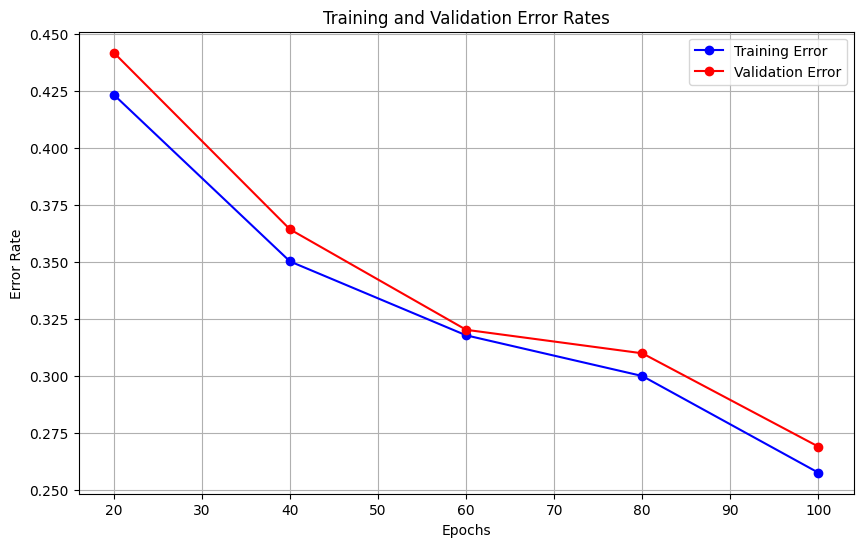

In [22]:
plot_curves(train_error_rates, val_error_rates)